# A method for computing Model Agnostic Effect Coefficients (MAgEC)

In [1]:
import numpy as np
import pandas as pd
import magec_utils as mg
import mimic_utils as mimic
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

pd.set_option('display.max_columns', None)

%matplotlib inline

Using TensorFlow backend.


## MIMIC-III Dataset
The MIMIC-III dataset contains de-identified records from patients admitted in an intensive care unit (ICU) at Beth Israel Deaconess Medical Center in Boston, Massachusetts in the period of June 2001 to October 2012. Following [Ren et al.] we identify non-surgical adult patients admitted at the hospital in ICU for the first time.  A cohort of 10415 patients is extracted for whom laboratory values (19 features), vital signs (8 features), comorbidities (3 features) and demographics (2 features) are measured. For each patient hourly data measurements are computed (with patients having at most 25 different time points) at least 3h prior to an event time (start of intubation or one day after transfer time to ICU for patients who underwent mechanical ventilation support and those who didn’t respectively). 

In [2]:
# MIMIC-III
df = mimic.get_mimic_data()
# Data featurized using 'last' measurements
df_ml = mimic.get_ml_data(df)
# Data featurized as time-series
df_time = mimic.get_ml_series_data(df)

In [3]:
# train/valid data for 'static' models (MLP/RF/LR)
x_train, x_validation, stsc, xst_train, xst_validation, Y_train, Y_validation = mimic.train_valid_ml(df_ml)

In [4]:
# train/valid data for LSTM
stsc2, df_series_train, df_series_valid, xt_train, Yt_train, \
xt_valid, Yt_valid = mimic.train_valid_series(df_time, Y_validation)

In [5]:
# Label weights 
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train['label']), Y_train['label'])
class_weights

array([0.61911131, 2.59887711])

### MIMIC-II MV Models
We split our cohort of 10415 patients into a train and validation set (using a 80/20 random split) and apply z-normalization for every feature (at every time point). We train a multi-layer perceptron (MLP), a random forest (RF) with calibrated probabilities using Platt’s method, and a logistic regression (LR) model using latest extracted features and a long-short-term (LSTM) model using all extracted time points. All four models are untuned. We compute MAgECs for each of the 2083 patients in the validation set for all models.

In [6]:
models = mimic.mimic_models(xst_train, Y_train, xt_train, Yt_train, class_weights)

In [7]:
mlp = models['mlp']
rf = models['rf']
lr = models['lr']
lstm = models['lstm']

In [8]:
mlp_accuracy, mlp_precision, mlp_recall, mlp_f1, mlp_auc = mg.evaluate(mlp, xst_validation, Y_validation['label'])

Accuracy: 0.858377
Precision: 0.774775
Recall: 0.412470
F1 score: 0.538341
ROC AUC: 0.802854
[[1616   50]
 [ 245  172]]


In [9]:
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc = mg.evaluate(rf, xst_validation, Y_validation['label'])

Accuracy: 0.804609
Precision: 0.589286
Recall: 0.079137
F1 score: 0.139535
ROC AUC: 0.816361
[[1643   23]
 [ 384   33]]


In [10]:
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc = mg.evaluate(lr, xst_validation, Y_validation['label'])

Accuracy: 0.662026
Precision: 0.329370
Recall: 0.664269
F1 score: 0.440382
ROC AUC: 0.711991
[[1102  564]
 [ 140  277]]


In [11]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_auc = mg.evaluate(lstm, xt_valid, Yt_valid)

Accuracy: 0.861738
Precision: 0.727915
Recall: 0.494005
F1 score: 0.588571
ROC AUC: 0.835737
[[1589   77]
 [ 211  206]]



| Model | Accuracy | Precision | Recall | F1 score | ROC AUC | Confusion Matrix              |
| :----:| :------: | :-------: | :-----:| :-------:| :-----: | :---------------------------: |
|  LR   |   0.66   |   0.32    |  0.66  |   0.44   |   0.71  |\|1102&nbsp;564\|<br />\|140&nbsp;&nbsp;277\||
|  RF   |   0.80   |   0.61    |  0.08  |   0.14   |   0.81  |\|1644&nbsp;22\|<br />\|382&nbsp;&nbsp;35\||
|  MLP  |   0.85   |   0.76    |  0.40  |   0.53   |   0.82  |\|1614&nbsp;52\|<br />\|247&nbsp;170\||
|  LSTM |   0.86   |   0.76    |  0.49  |   0.60   |   0.83  |\|1603&nbsp;&nbsp;63\|<br />\|210&nbsp;&nbsp;207\||
<br/>
* note: Model Performance Metrics may slightly differ every time you train the models

### MIMIC-III MAgECs

In [12]:
joined = pd.read_csv('time_mimic_magecs.csv')

In [13]:
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']
labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit
comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']
others = ['age', 'gender']

In [14]:
features = vitals+labs
weights_auc = {'mlp': 0.82, 'rf': 0.81, 'lr': 0.71, 'lstm': 0.83}
weights_recall = {'mlp': 0.4, 'rf': 0.08, 'lr': 0.66, 'lstm': 0.49}
models = ('mlp', 'rf', 'lr', 'lstm')
ranks = mg.magec_rank(joined, rank=len(features), features=features, models=models)
consensus_auc = mg.magec_consensus(ranks, use_weights=True, weights=weights_auc, models=models)
consensus_recall = mg.magec_consensus(ranks, use_weights=True, weights=weights_recall, models=models)
rbos = mg.magec_rbos(ranks, models=models)

## Panel Plots

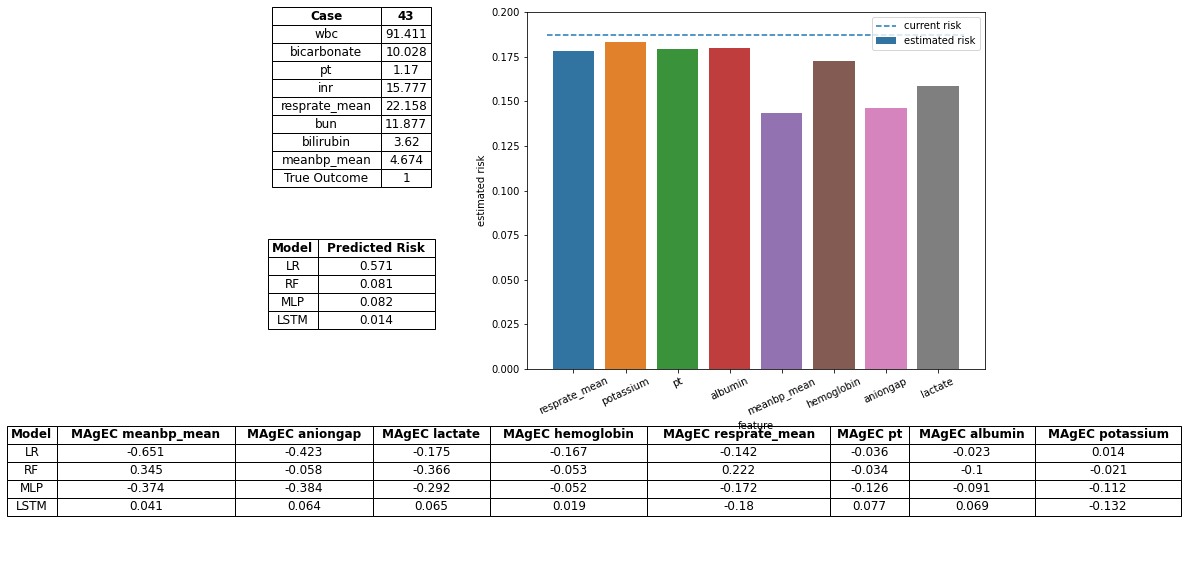

In [17]:
case = 43
timepoint = 3
mg.panel_plot(xst_train.columns, features, stsc, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25)

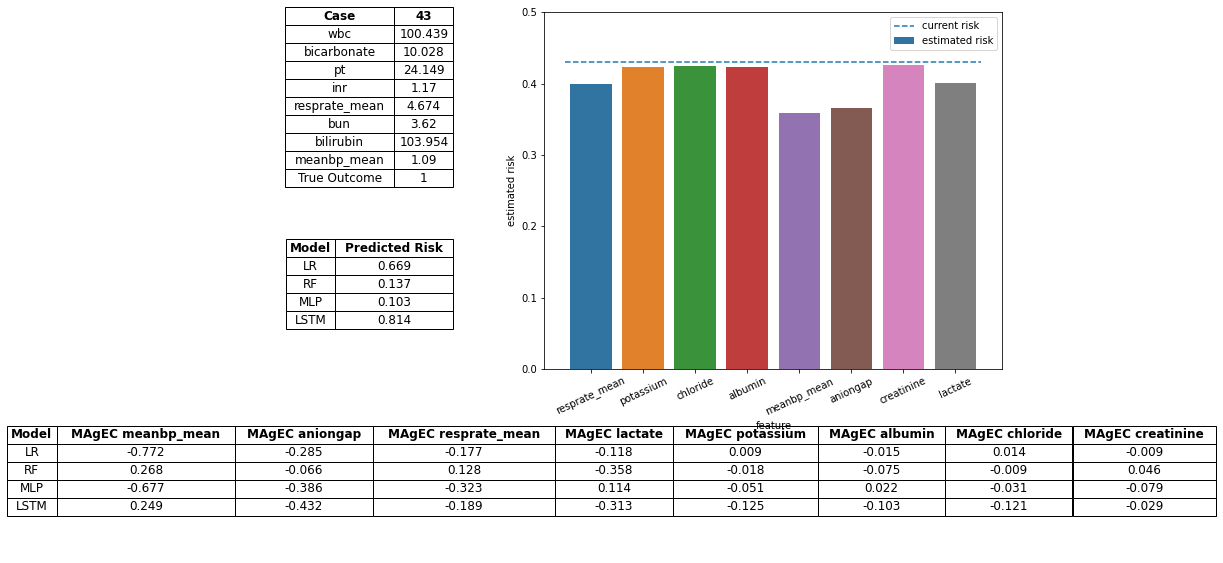

In [18]:
case = 43
timepoint = 27
mg.panel_plot(xst_train.columns, features, stsc, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25)